In [ ]:
# jitter_index
# speed_mean
# speed_std
# speed_max
# acc_mean
# acc_std
# acc_max
# jerk_mean
# jerk_std
# jerk_max
# dt_mean
# dt_std
# dt_max
# curvature

In [25]:
import os
import json
import re
import math
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
BASE_DIR = "/Users/naman/sem_1_2025_26/scalable_computing/final_project/mouse_training/web_bot_detection_dataset"

In [15]:
def parse_mouse_json(record: dict) -> Tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Parse one mouse_movements.json record into:
      times: np.ndarray shape (N,)  - timestamps (ms or similar)
      xs:    np.ndarray shape (N,)  - x positions
      ys:    np.ndarray shape (N,)  - y positions

    Returns (None, None, None) if not enough points.
    """

    # ---- times ----
    times_raw = record.get("mousemove_times", "")
    times: List[int] = []

    if "(" in times_raw or "{" in times_raw:
        # e.g. "{(259860030),(259860045),...}"
        times = [int(t) for t in re.findall(r"\((\d+)\)", times_raw)]
    else:
        # e.g. "259860030,259860045,259860064"
        times = [int(t) for t in times_raw.split(",") if t.strip().isdigit()]

    # ---- coordinates ----
    coords_raw = record.get("mousemove_total_behaviour", "")
    coords = re.findall(r"[\(\[]\s*(\d+)\s*,\s*(\d+)\s*[\)\]]", coords_raw)
    xs = [int(x) for x, _ in coords]
    ys = [int(y) for _, y in coords]

    n = min(len(times), len(xs), len(ys))
    if n < 20:  # too short
        return None, None, None

    times_arr = np.array(times[:n], dtype=np.float64)
    xs_arr    = np.array(xs[:n], dtype=np.float64)
    ys_arr    = np.array(ys[:n], dtype=np.float64)

    return times_arr, xs_arr, ys_arr

In [19]:
test_path = "/Users/naman/sem_1_2025_26/scalable_computing/final_project/mouse_training/web_bot_detection_dataset/phase1/data/mouse_movements/humans_and_advanced_bots/0i5kvpslrq3vb6u8ff2kuejv0v/mouse_movements.json"  # or your own example
with open(test_path, "r") as f:
    rec = json.load(f)

times_test, xs_test, ys_test = parse_mouse_json(rec)
print(times_test.shape, xs_test.shape, ys_test.shape)
print(times_test[:5], xs_test[:5], ys_test[:5])



(8584,) (8584,) (8584,)
[6.25982432e+08 6.25982440e+08 6.25982452e+08 6.25982469e+08
 6.25982485e+08] [ 7. 15. 23. 31. 39.] [ 6. 14. 22. 29. 37.]


In [20]:
def slice_session(
    times: np.ndarray,
    xs: np.ndarray,
    ys: np.ndarray,
    window_seconds: float = 60.0,
    min_points: int = 20,
) -> List[Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Slice (times, xs, ys) into non-overlapping windows of given length.
    times are assumed in ms (or consistent unit).
    Returns list of (times_rel, xs_slice, ys_slice).
    """
    if len(times) < min_points:
        return []

    window_ms = window_seconds * 1000.0
    slices: List[Tuple[np.ndarray, np.ndarray, np.ndarray]] = []

    start_time = times[0]
    end_time   = times[-1]
    cur_start  = start_time

    while cur_start + window_ms <= end_time:
        cur_end = cur_start + window_ms
        mask = (times >= cur_start) & (times < cur_end)

        if mask.sum() >= min_points:
            t_slice = times[mask] - cur_start  # make relative (start at 0)
            x_slice = xs[mask]
            y_slice = ys[mask]
            slices.append((t_slice, x_slice, y_slice))

        cur_start = cur_end  # move to next window

    return slices

In [21]:
def normalize_window(xs: np.ndarray, ys: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalize x, y to [0,1] per window based on max values in that window.
    """
    x_max = xs.max() if xs.size > 0 else 1.0
    y_max = ys.max() if ys.size > 0 else 1.0

    if x_max == 0: x_max = 1.0
    if y_max == 0: y_max = 1.0

    xs_norm = xs / x_max
    ys_norm = ys / y_max
    return xs_norm, ys_norm

In [22]:
def extract_features(times: np.ndarray,
                     xs: np.ndarray,
                     ys: np.ndarray) -> dict:
    """
    Extract features from one window.
    Returns a dict ready to be appended into a pandas DataFrame.
    """

    # times in seconds
    t = times.astype(np.float64) / 1000.0
    if len(t) < 2:
        return {
            "duration": 0.0,
            "path_length": 0.0,
            "displacement": 0.0,
            "straightness": 0.0,
            "jitter_index": 0.0,
            "speed_mean": 0.0, "speed_std": 0.0, "speed_max": 0.0,
            "acc_mean": 0.0,   "acc_std": 0.0,   "acc_max": 0.0,
            "jerk_mean": 0.0,  "jerk_std": 0.0,  "jerk_max": 0.0,
            "dt_mean": 0.0,    "dt_std": 0.0,    "dt_max": 0.0,
            "curvature": 0.0,
            "n_points": float(len(xs)),
        }

    dt = np.diff(t)
    dx = np.diff(xs)
    dy = np.diff(ys)
    dist = np.sqrt(dx * dx + dy * dy)

    dt_safe = np.where(dt == 0, 1e-6, dt)
    speed = dist / dt_safe

    acc = np.diff(speed)
    jerk = np.diff(acc) if len(acc) > 1 else np.array([0.0])

    duration = t[-1] - t[0]
    path_length = dist.sum()
    displacement = math.dist((xs[0], ys[0]), (xs[-1], ys[-1]))
    straightness = displacement / path_length if path_length > 0 else 0.0
    jitter_index = (path_length / displacement) if displacement > 0 else 1.0

    def stats(arr: np.ndarray):
        if arr.size == 0:
            return 0.0, 0.0, 0.0
        return float(arr.mean()), float(arr.std()), float(arr.max())

    speed_mean, speed_std, speed_max = stats(speed)
    acc_mean, acc_std, acc_max       = stats(acc)
    jerk_mean, jerk_std, jerk_max    = stats(jerk)
    dt_mean, dt_std, dt_max          = stats(dt)

    # curvature
    if len(dx) > 1:
        v1 = np.stack([dx[:-1], dy[:-1]], axis=1)
        v2 = np.stack([dx[1:],  dy[1:]],  axis=1)
        dot = np.sum(v1 * v2, axis=1)
        norms = np.linalg.norm(v1, axis=1) * np.linalg.norm(v2, axis=1)
        norms = np.where(norms == 0, 1e-6, norms)
        cos = np.clip(dot / norms, -1.0, 1.0)
        angles = np.arccos(cos)
        curvature = float(angles.mean())
    else:
        curvature = 0.0

    return {
        "duration": float(duration),
        "path_length": float(path_length),
        "displacement": float(displacement),
        "straightness": float(straightness),
        "jitter_index": float(jitter_index),

        "speed_mean": float(speed_mean),
        "speed_std": float(speed_std),
        "speed_max": float(speed_max),

        "acc_mean": float(acc_mean),
        "acc_std": float(acc_std),
        "acc_max": float(acc_max),

        "jerk_mean": float(jerk_mean),
        "jerk_std": float(jerk_std),
        "jerk_max": float(jerk_max),

        "dt_mean": float(dt_mean),
        "dt_std": float(dt_std),
        "dt_max": float(dt_max),

        "curvature": float(curvature),
        "n_points": float(len(xs)),
    }

In [23]:
slices_test = slice_session(times_test, xs_test, ys_test, window_seconds=60, min_points=20)
len(slices_test)

if slices_test:
    t0, x0, y0 = slices_test[0]
    x0n, y0n = normalize_window(x0, y0)
    feat_dict = extract_features(t0, x0n, y0n)
    pd.Series(feat_dict)

In [24]:
def load_phase_subset_to_df(
    mouse_root_dir: str,
    annotation_path: str,
    window_seconds: float = 60.0,
    min_points: int = 20,
    phase_name: str = "",
    subset_name: str = "",
) -> pd.DataFrame:
    """
    mouse_root_dir: folder with per-session subfolders
    annotation_path: TXT with "<session_id> <label>"
    Returns:
      DataFrame with one row per window, columns=features + ['label', 'session_id', 'phase', 'subset']
    """

    # --- load annotations into pandas ---
    annot_df = pd.read_csv(
        annotation_path,
        sep=r"\s+",
        header=None,
        names=["session_id", "raw_label"],
        engine="python",
    )

    # binary label: 1 = human, 0 = bot (moderate or advanced)
    annot_df["label"] = annot_df["raw_label"].str.lower().str.contains("human").astype(int)

    rows = []

    for _, row in annot_df.iterrows():
        session_id = str(row["session_id"])
        label = int(row["label"])

        session_dir = os.path.join(mouse_root_dir, session_id)
        json_path = os.path.join(session_dir, "mouse_movements.json")
        if not os.path.exists(json_path):
            continue

        with open(json_path, "r") as f:
            rec = json.load(f)

        times, xs, ys = parse_mouse_json(rec)
        if times is None:
            continue

        windows = slice_session(
            times, xs, ys,
            window_seconds=window_seconds,
            min_points=min_points,
        )

        for (tw, xw, yw) in windows:
            x_norm, y_norm = normalize_window(xw, yw)
            feat = extract_features(tw, x_norm, y_norm)
            feat["label"] = label
            feat["session_id"] = session_id
            feat["phase"] = phase_name
            feat["subset"] = subset_name
            rows.append(feat)

    if not rows:
        return pd.DataFrame()

    df = pd.DataFrame(rows)
    return df

In [26]:
p1_hab_mouse_dir_train = os.path.join(
    BASE_DIR, "phase1", "data", "mouse_movements", "humans_and_advanced_bots"
)

p1_hab_annot_train = os.path.join(
    BASE_DIR, "phase1", "annotations", "humans_and_advanced_bots", "train"
)

print(p1_hab_mouse_dir_train)
print(p1_hab_annot_train)


/Users/naman/sem_1_2025_26/scalable_computing/final_project/mouse_training/web_bot_detection_dataset/phase1/data/mouse_movements/humans_and_advanced_bots
/Users/naman/sem_1_2025_26/scalable_computing/final_project/mouse_training/web_bot_detection_dataset/phase1/annotations/humans_and_advanced_bots/train


In [27]:
p1_hmb_mouse_dir_train = os.path.join(
    BASE_DIR, "phase1", "data", "mouse_movements", "humans_and_moderate_bots"
)

p1_hmb_annot_train = os.path.join(
    BASE_DIR, "phase1", "annotations", "humans_and_moderate_bots", "train"
)

In [28]:
df_p1_hab_train = load_phase_subset_to_df(
    mouse_root_dir=p1_hab_mouse_dir_train,
    annotation_path=p1_hab_annot_train,
    window_seconds=60.0,
    min_points=20,
    phase_name="phase1",
    subset_name="humans_and_advanced_bots_train",
)

df_p1_hmb_train = load_phase_subset_to_df(
    mouse_root_dir=p1_hmb_mouse_dir_train,
    annotation_path=p1_hmb_annot_train,
    window_seconds=60.0,
    min_points=20,
    phase_name="phase1",
    subset_name="humans_and_moderate_bots_train",
)

print(df_p1_hab_train.shape, df_p1_hmb_train.shape)

(354, 23) (241, 23)


In [76]:
pd.set_option("display.max_columns", None)
list(df_p1_hab_train.columns)


['duration',
 'path_length',
 'displacement',
 'straightness',
 'jitter_index',
 'speed_mean',
 'speed_std',
 'speed_max',
 'acc_mean',
 'acc_std',
 'acc_max',
 'jerk_mean',
 'jerk_std',
 'jerk_max',
 'dt_mean',
 'dt_std',
 'dt_max',
 'curvature',
 'n_points',
 'label',
 'session_id',
 'phase',
 'subset']

In [80]:
import numpy as np

def extract_features(times, xs, ys):
    """
    Rich feature extractor, matching the first df's schema:

    Returns columns:
      duration, path_length, displacement, straightness,
      jitter_index,
      speed_mean, speed_std, speed_max,
      acc_mean, acc_std, acc_max,
      jerk_mean, jerk_std, jerk_max,
      dt_mean, dt_std, dt_max,
      curvature,
      n_points
    """
    times = np.asarray(times, dtype=np.float64)
    xs = np.asarray(xs, dtype=np.float64)
    ys = np.asarray(ys, dtype=np.float64)

    n = len(times)
    if n < 2:
        return {
            "duration": 0.0,
            "path_length": 0.0,
            "displacement": 0.0,
            "straightness": 0.0,
            "jitter_index": 0.0,
            "speed_mean": 0.0,
            "speed_std": 0.0,
            "speed_max": 0.0,
            "acc_mean": 0.0,
            "acc_std": 0.0,
            "acc_max": 0.0,
            "jerk_mean": 0.0,
            "jerk_std": 0.0,
            "jerk_max": 0.0,
            "dt_mean": 0.0,
            "dt_std": 0.0,
            "dt_max": 0.0,
            "curvature": 0.0,
            "n_points": float(n),
        }

    # durations (ms)
    duration = float(times[-1] - times[0])

    # dt in seconds
    dt = np.diff(times) / 1000.0
    dt[dt <= 0] = 1e-6

    # displacements between consecutive points
    dx = np.diff(xs)
    dy = np.diff(ys)
    dist = np.sqrt(dx * dx + dy * dy)

    path_length = float(dist.sum())
    displacement = float(np.sqrt((xs[-1] - xs[0])**2 + (ys[-1] - ys[0])**2))
    straightness = displacement / path_length if path_length > 0 else 0.0

    # "jitter" as extra distance vs straight line
    jitter_index = (path_length - displacement) / (displacement + 1e-6) if displacement > 0 else 0.0

    # speed
    speed = dist / dt
    speed_mean = float(speed.mean())
    speed_std = float(speed.std(ddof=0))
    speed_max = float(speed.max())

    # acceleration (based on speed)
    if len(speed) > 1:
        dt_acc = dt[1:]
        dt_acc[dt_acc <= 0] = 1e-6
        accel = np.diff(speed) / dt_acc
        acc_abs = np.abs(accel)
        acc_mean = float(acc_abs.mean())
        acc_std = float(acc_abs.std(ddof=0))
        acc_max = float(acc_abs.max())
    else:
        acc_mean = acc_std = acc_max = 0.0
        accel = np.array([], dtype=np.float64)

    # jerk (change of acceleration)
    if len(accel) > 1:
        dt_jerk = dt[2:] if len(dt) >= 3 else np.array([1.0])
        dt_jerk = np.maximum(dt_jerk, 1e-6)
        jerk = np.diff(accel) / dt_jerk[:len(np.diff(accel))]
        jerk_abs = np.abs(jerk)
        jerk_mean = float(jerk_abs.mean())
        jerk_std = float(jerk_abs.std(ddof=0))
        jerk_max = float(jerk_abs.max())
    else:
        jerk_mean = jerk_std = jerk_max = 0.0

    # curvature: mean absolute change in heading angle per segment
    if len(dx) > 1:
        v1x, v1y = dx[:-1], dy[:-1]
        v2x, v2y = dx[1:], dy[1:]
        dot = v1x * v2x + v1y * v2y
        norm1 = np.sqrt(v1x * v1x + v1y * v1y)
        norm2 = np.sqrt(v2x * v2x + v2y * v2y)
        denom = norm1 * norm2
        denom[denom == 0] = 1e-6
        cos_theta = np.clip(dot / denom, -1.0, 1.0)
        angles = np.arccos(cos_theta)  # radians
        curvature = float(np.mean(np.abs(angles)))
    else:
        curvature = 0.0

    return {
        "duration": duration,
        "path_length": path_length,
        "displacement": displacement,
        "straightness": straightness,
        "jitter_index": jitter_index,
        "speed_mean": speed_mean,
        "speed_std": speed_std,
        "speed_max": speed_max,
        "acc_mean": acc_mean,
        "acc_std": acc_std,
        "acc_max": acc_max,
        "jerk_mean": jerk_mean,
        "jerk_std": jerk_std,
        "jerk_max": jerk_max,
        "dt_mean": float(dt.mean()),
        "dt_std": float(dt.std(ddof=0)),
        "dt_max": float(dt.max()),
        "curvature": curvature,
        "n_points": float(n),
    }

In [81]:
PHASE2_BASE = "/Users/naman/sem_1_2025_26/scalable_computing/final_project/mouse_training/web_bot_detection_dataset/phase2"

ann_phase2_hmab = os.path.join(
    PHASE2_BASE,
    "annotations",
    "humans_and_moderate_and_advanced_bots",
    "humans_and_moderate_and_advanced_bots",
)

humans_file_phase2 = os.path.join(
    PHASE2_BASE,
    "data",
    "mouse_movements",
    "humans",
    "mouse_movements_humans.json",
)

bots_dir_phase2 = os.path.join(
    PHASE2_BASE,
    "data",
    "mouse_movements",
    "bots",
)

df_phase2 = load_phase2_to_df(
    annotation_path=ann_phase2_hmab,
    humans_file=humans_file_phase2,
    bots_dir=bots_dir_phase2,
    window_seconds=60.0,
    min_points=20,
    subset_name="phase2_hmab",
)

print(df_phase2.shape)
print(df_phase2.head())

(1316, 22)
   duration  path_length  displacement  straightness  jitter_index  \
0   59990.0     6.696846      0.525676      0.078496     11.739484   
1   59981.0     3.340945      0.300146      0.089839     10.131018   
2   59940.0     6.037206      0.513523      0.085060     10.756437   
3   59673.0     3.540497      0.516117      0.145775      5.859860   
4   47727.0     7.716309      0.397166      0.051471     18.428364   

   speed_mean    speed_std     speed_max      acc_mean       acc_std  \
0   78.742885  2533.803648  81987.640971  7.845753e+07  2.534987e+09   
1    0.227853     0.430129      5.842658  5.456315e+00  1.678149e+01   
2    0.353461     0.545656      6.022135  6.934909e+00  1.280488e+01   
3    0.310403     0.597915      7.753441  9.525905e+00  3.267751e+01   
4    0.335798     0.588874      4.563968  7.843137e+00  1.785879e+01   

        acc_max     jerk_mean      jerk_std      jerk_max   dt_mean    dt_std  \
0  8.198640e+10  7.853267e+13  2.536200e+15  8.198640e

In [72]:
print("humans_index:", len(index_from_ndjson(humans_file_phase2)))

bot_idx = {}
for f in os.listdir(bots_dir_phase2):
    if f.endswith(".json"):
        bot_idx = index_from_ndjson(os.path.join(bots_dir_phase2, f), bot_idx)
print("bots_index:", len(bot_idx))

print("annotations:", len(pd.read_csv(ann_phase2_hmab, sep=r'\s+', header=None)))

humans_index: 59
bots_index: 240
annotations: 112


In [77]:
# 1) Load annotations as DataFrame
annot_df = pd.read_csv(
    ann_phase2_hmab,
    sep=r"\s+",
    header=None,
    names=["session_id", "raw_label"],
    engine="python",
)
annot_df["label"] = annot_df["raw_label"].str.contains("human", case=False).astype(int)

annot_sids = set(annot_df["session_id"].astype(str))

# 2) Rebuild indices (or reuse if you already have them)
humans_index = index_from_ndjson(humans_file_phase2)
bots_index = {}
for f in os.listdir(bots_dir_phase2):
    if f.endswith(".json"):
        bots_index = index_from_ndjson(os.path.join(bots_dir_phase2, f), bots_index)

human_sids = set(humans_index.keys())
bot_sids   = set(bots_index.keys())

print("annotations total:", len(annot_sids))
print("human_index total:", len(human_sids))
print("bot_index total  :", len(bot_sids))

print("annot ∩ humans:", len(annot_sids & human_sids))
print("annot ∩ bots  :", len(annot_sids & bot_sids))

print("sample annot∩humans:", list(annot_sids & human_sids)[:5])
print("sample annot∩bots  :", list(annot_sids & bot_sids)[:5])

annotations total: 100
human_index total: 59
bot_index total  : 240
annot ∩ humans: 44
annot ∩ bots  : 56
sample annot∩humans: ['p5keafiscisucgq2tut00s0s7l', 'j8e0t5t4nnr92fupp8rh18ihkq', 'rh5fn2njcglhb2avkv30id017u', '36rja5utab0pakj5136bi7rkop', '89vshcu5jgp79ebb68f7jjkqc5']
sample annot∩bots  : ['62fp2u5etekvin0lrlmmq7ras2', '7e7nf7k4fcjagt3nasaihu4scq', '2cod58pj6b57pun9fl0vhiqoia', '27479tfiqfgi99u7r4vq0q33db', '7jtk8r1ak181fhbf582hjhvbdq']


In [83]:
(set(df_p1_hab_train.columns) - set(df_phase2.columns))

{'phase'}

In [84]:
x = df_phase2.columns

In [85]:
df_phase1 = pd.concat([df_p1_hab_train, df_phase2], ignore_index=True)

In [96]:
df_phase1 = df_phase1[x]
df_phase1.drop_duplicates(subset=x)
df_phase1

,duration,path_length,displacement,straightness,jitter_index,speed_mean,speed_std,speed_max,acc_mean,acc_std,acc_max,jerk_mean,jerk_std,jerk_max,dt_mean,dt_std,dt_max,curvature,n_points,label,session_id,subset
0,59.997,7.636607,0.689687,0.090313,11.072575,0.297785,0.692877,22.877720,-0.001763,0.868391,22.858958,0.000716,1.497760,23.016624,0.040814,0.192476,4.306,0.250571,1471.0,1,dr09rk5eagjuu87gedvdqmq3gl,humans_and_advanced_bots_train
1,59.632,10.523313,0.133968,0.012731,78.551161,0.273583,0.435429,5.193537,-0.000030,0.219044,2.958642,-0.000089,0.348174,4.803080,0.026017,0.067867,1.417,0.201213,2293.0,1,dr09rk5eagjuu87gedvdqmq3gl,humans_and_advanced_bots_train
2,57.527,8.988508,0.724884,0.080646,12.399924,0.262647,0.369822,4.102115,-0.000072,0.172747,1.614636,0.000038,0.254852,1.832012,0.028706,0.085258,1.800,0.252065,2005.0,1,dr09rk5eagjuu87gedvdqmq3gl,humans_and_advanced_bots_train
3,59.561,10.674577,0.196980,0.018453,54.191255,0.284308,0.374481,4.190250,0.000489,0.198214,2.155542,0.000045,0.310341,3.366794,0.026519,0.092578,2.545,0.218297,2247.0,1,dr09rk5eagjuu87gedvdqmq3gl,humans_and_advanced_bots_train
4,59.996,11.378064,1.028964,0.090434,11.057782,0.304364,0.505306,6.779101,-0.000061,0.318139,5.125661,-0.000029,0.542011,6.780530,0.026952,0.081551,1.903,0.217555,2227.0,1,gq715ms79515gcq39vf91mli6t,humans_and_advanced_bots_train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,36820.000,10.689306,0.973135,0.091038,9.984397,0.351051,0.594303,24.569783,6.108003,48.498893,1498.461561,706.657019,5153.560203,181667.642071,0.020142,0.052881,1.402,0.157353,1829.0,0,bdsf9dba41deu2j4744onppg6k,phase2_hmab
1666,54664.000,14.809452,0.448483,0.030284,32.021125,0.363867,0.733649,35.558007,5.660575,64.731595,2334.725982,656.274689,6973.669125,282512.905980,0.022275,0.177278,8.515,0.168213,2455.0,0,bdsf9dba41deu2j4744onppg6k,phase2_hmab
1667,59998.000,11.958783,0.471671,0.039441,24.354003,0.364874,0.227506,5.562442,4.632244,13.209250,348.394095,534.441153,1508.874233,48558.860351,0.030502,0.356713,11.346,0.154374,1968.0,0,bdsf9dba41deu2j4744onppg6k,phase2_hmab
1668,34117.000,10.551241,0.564034,0.053457,17.706728,0.358841,0.479124,19.123591,5.262979,39.526835,1178.866372,598.840564,4231.477963,146070.747282,0.019188,0.051568,1.410,0.149533,1779.0,0,bdsf9dba41deu2j4744onppg6k,phase2_hmab


In [88]:
df_all = pd.concat([df_phase1, df_phase2], ignore_index=True)

In [63]:
df_all.columns

(2986, 22)

In [97]:
import numpy as np

# Columns that are NOT features
non_feature_cols = ["label", "session_id", "phase", "subset"]

feature_cols = [c for c in df_all.columns if c not in non_feature_cols]
print("Number of features:", len(feature_cols))
print("Feature columns:", feature_cols)

X_all = df_all[feature_cols].astype(float).values
y_all = df_all["label"].astype(int).values

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape, " | class distribution:", np.bincount(y_all))

Number of features: 19
Feature columns: ['duration', 'path_length', 'displacement', 'straightness', 'jitter_index', 'speed_mean', 'speed_std', 'speed_max', 'acc_mean', 'acc_std', 'acc_max', 'jerk_mean', 'jerk_std', 'jerk_max', 'dt_mean', 'dt_std', 'dt_max', 'curvature', 'n_points']
X_all shape: (2986, 19)
y_all shape: (2986,)  | class distribution: [ 494 2492]


In [104]:
unique_sids = df_all["session_id"].unique()

from sklearn.model_selection import train_test_split

train_sids, test_sids = train_test_split(
    unique_sids,
    test_size=0.2,
    random_state=42,
    stratify=df_all.groupby("session_id")["label"].first()
)

train_df = df_all[df_all["session_id"].isin(train_sids)]
test_df  = df_all[df_all["session_id"].isin(test_sids)]

X_train = train_df[feature_cols].values
y_train = train_df["label"].values

X_valid = test_df[feature_cols].values
y_valid = test_df["label"].values

In [105]:
from xgBoost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [106]:
importances = xgb_model.feature_importances_
for f, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1])[:15]:
    print(f, imp)

curvature 0.2737692
n_points 0.13553578
acc_mean 0.1024635
acc_std 0.08756704
jerk_std 0.07738114
speed_mean 0.07100623
speed_std 0.06796702
speed_max 0.033086095
jerk_mean 0.02965112
dt_mean 0.01915154
duration 0.019084891
acc_max 0.016181665
straightness 0.016133225
path_length 0.016002985
dt_max 0.011395711


In [107]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# Probabilities and hard predictions
y_valid_proba = xgb_model.predict_proba(X_valid)[:, 1]
y_valid_pred  = (y_valid_proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_valid, y_valid_proba))
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("F1 score:", f1_score(y_valid, y_valid_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_valid, y_valid_pred))

print("\nClassification report:")
print(classification_report(y_valid, y_valid_pred, digits=4))

ROC AUC: 1.0
Accuracy: 0.9954022988505747
F1 score: 0.9972677595628415

Confusion matrix:
[[ 68   2]
 [  0 365]]

Classification report:
              precision    recall  f1-score   support

           0     1.0000    0.9714    0.9855        70
           1     0.9946    1.0000    0.9973       365

    accuracy                         0.9954       435
   macro avg     0.9973    0.9857    0.9914       435
weighted avg     0.9954    0.9954    0.9954       435



In [108]:
import joblib

joblib.dump(xgb_model, "mouse_model_xgb.pkl")

['mouse_model_xgb.pkl']

In [109]:
model = joblib.load("mouse_model_xgb.pkl")

In [85]:
import pandas as pd

# ---- change this path ----
csv_path = "dfl_scores.csv"
# ---------------------------

df = pd.read_csv(csv_path)

print("\n=== Basic Info ===")
print(df.info())

print("\n=== Summary Statistics ===")
print(df["human_likeness_score"].describe())

# print("\n=== Top 20 Most Human-like ===")
# print(df.nlargest(20, "human_likeness_score"))
#
# print("\n=== Bottom 20 (Most Bot-like) ===")
# print(df.nsmallest(20, "human_likeness_score"))
#
# # Distribution buckets
# print("\n=== Score Buckets ===")
# bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
# labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
# df["bucket"] = pd.cut(df["human_likeness_score"], bins=bins, labels=labels, include_lowest=True)
# print(df["bucket"].value_counts().sort_index())
#
# # If you want a threshold for classification:
# threshold = 0.5
# df["predicted_human"] = df["human_likeness_score"] >= threshold
#
# print("\n=== Predicted distribution (threshold=0.5) ===")
# print(df["predicted_human"].value_counts())
#
# print("\n=== Example: Most human-like files ===")
# print(df[df["predicted_human"]].head())
#
# print("\n=== Example: Most bot-like files ===")
# print(df[~df["predicted_human"]].head())


=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   file                  31 non-null     object 
 1   n_points              31 non-null     int64  
 2   human_likeness_score  31 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 876.0+ bytes
None

=== Summary Statistics ===
count    31.000000
mean      0.779061
std       0.087626
min       0.598619
25%       0.752345
50%       0.772029
75%       0.830537
max       0.985197
Name: human_likeness_score, dtype: float64


In [70]:
df_h = pd.read_csv("attentive_scores.csv")       # human
df_b = pd.read_csv("test_set_scores.csv")   # jitter bots

for t in [0.1, 0.2, 0.3, 0.4, 0.5]:
    ph = (df_h["human_likeness_score"] >= t).mean()
    pb = (df_b["human_likeness_score"] >= t).mean()
    print(f"Threshold {t:.2f} → humans: {ph:.3f}, bots: {pb:.3f}")

Threshold 0.10 → humans: 0.256, bots: 0.375
Threshold 0.20 → humans: 0.162, bots: 0.145
Threshold 0.30 → humans: 0.116, bots: 0.070
Threshold 0.40 → humans: 0.084, bots: 0.015
Threshold 0.50 → humans: 0.061, bots: 0.000


In [53]:
import os
import json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

# ====== CHANGE THESE PATHS TO MATCH YOUR PROJECT ======
MODEL_PATH = "mouse_model_xgb_2.pkl"
SESSIONS_PATH = "sessions.json"   # your sessions.json used for training

# Optional: CSVs with scores you already computed
HUMAN_SCORES_CSV = "attentive_scores.csv"          # file,human_likeness_score
BOT_JITTER_SCORES_CSV = "test_set_scores.csv"
# ======================================================

In [54]:
feature_cols = [
    "duration", "path_length", "displacement", "straightness",
    "jitter_index", "speed_mean", "speed_std", "speed_max",
    "acc_mean", "acc_std", "acc_max",
    "jerk_mean", "jerk_std", "jerk_max",
    "dt_mean", "dt_std", "dt_max",
    "curvature", "n_points"
]

def extract_features(times, xs_norm, ys_norm):
    times = np.array(times, dtype=float)
    xs = np.array(xs_norm, dtype=float)
    ys = np.array(ys_norm, dtype=float)

    n_points = len(xs)
    if n_points == 0 or len(times) == 0:
        return {
            "duration": 0.0,
            "path_length": 0.0,
            "displacement": 0.0,
            "straightness": 0.0,
            "jitter_index": 0.0,
            "speed_mean": 0.0,
            "speed_std": 0.0,
            "speed_max": 0.0,
            "acc_mean": 0.0,
            "acc_std": 0.0,
            "acc_max": 0.0,
            "jerk_mean": 0.0,
            "jerk_std": 0.0,
            "jerk_max": 0.0,
            "dt_mean": 0.0,
            "dt_std": 0.0,
            "dt_max": 0.0,
            "curvature": 0.0,
            "n_points": 0,
        }

    duration = times[-1] - times[0] if n_points > 1 else 0.0

    dx = np.diff(xs)
    dy = np.diff(ys)
    dist = np.sqrt(dx * dx + dy * dy)
    path_length = dist.sum()

    displacement = np.sqrt((xs[-1] - xs[0]) ** 2 + (ys[-1] - ys[0]) ** 2)
    straightness = displacement / path_length if path_length > 0 else 0.0

    dts = np.diff(times)
    dt_mean = dts.mean() if len(dts) else 0.0
    dt_std = dts.std() if len(dts) else 0.0
    dt_max = dts.max() if len(dts) else 0.0

    # speeds
    if len(dist) and len(dts):
        with np.errstate(divide="ignore", invalid="ignore"):
            speeds = dist / dts
        speeds[~np.isfinite(speeds)] = 0.0
    else:
        speeds = np.array([0.0])

    speed_mean = speeds.mean()
    speed_std = speeds.std()
    speed_max = speeds.max()

    # acceleration
    acc = np.diff(speeds) if len(speeds) > 1 else np.array([0.0])
    acc[~np.isfinite(acc)] = 0.0
    acc_mean = acc.mean()
    acc_std = acc.std()
    acc_max = acc.max()

    # jerk
    jerk = np.diff(acc) if len(acc) > 1 else np.array([0.0])
    jerk[~np.isfinite(jerk)] = 0.0
    jerk_mean = jerk.mean()
    jerk_std = jerk.std()
    jerk_max = jerk.max()

    # jitter index
    if len(xs) > 2:
        jitter = np.abs(np.diff(xs, 2)).sum() + np.abs(np.diff(ys, 2)).sum()
    else:
        jitter = 0.0

    curvature = 0.0
    if len(xs) > 2:
        for i in range(1, len(xs) - 1):
            v1 = np.array([xs[i] - xs[i - 1], ys[i] - ys[i - 1]])
            v2 = np.array([xs[i + 1] - xs[i], ys[i + 1] - ys[i]])
            n1 = np.linalg.norm(v1)
            n2 = np.linalg.norm(v2)
            if n1 > 1e-6 and n2 > 1e-6:
                dot = np.dot(v1, v2) / (n1 * n2)
                dot = np.clip(dot, -1.0, 1.0)
                curvature += np.arccos(dot)

    return {
        "duration": float(duration),
        "path_length": float(path_length),
        "displacement": float(displacement),
        "straightness": float(straightness),
        "jitter_index": float(jitter),
        "speed_mean": float(speed_mean),
        "speed_std": float(speed_std),
        "speed_max": float(speed_max),
        "acc_mean": float(acc_mean),
        "acc_std": float(acc_std),
        "acc_max": float(acc_max),
        "jerk_mean": float(jerk_mean),
        "jerk_std": float(jerk_std),
        "jerk_max": float(jerk_max),
        "dt_mean": float(dt_mean),
        "dt_std": float(dt_std),
        "dt_max": float(dt_max),
        "curvature": float(curvature),
        "n_points": int(n_points),
    }


def load_mouse_trace(path):
    times = []
    xs = []
    ys = []
    viewport_w = viewport_h = None

    with open(path, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith("resolution:"):
                _, res = line.split(":")
                w, h = res.split(",")
                viewport_w = float(w)
                viewport_h = float(h)
                continue

            parts = line.split(",")
            if len(parts) != 4:
                continue

            t, event, x, y = parts
            if event != "Move":
                continue

            times.append(float(t))
            xs.append(float(x))
            ys.append(float(y))

    if viewport_w is None:
        raise ValueError(f"Resolution line missing in {path}")

    return np.array(times), np.array(xs), np.array(ys), viewport_w, viewport_h

In [55]:
def resolve_path(base_dir, rel_or_abs):
    if os.path.isabs(rel_or_abs):
        return rel_or_abs
    return os.path.normpath(os.path.join(base_dir, rel_or_abs))


def build_dataset_from_sessions(sessions_path):
    with open(sessions_path, "r") as f:
        sessions = json.load(f)

    base_dir = os.path.dirname(os.path.abspath(sessions_path))

    rows = []
    labels = []
    files = []

    # humans => 1
    for rel_path in sessions.get("human", []):
        full_path = resolve_path(base_dir, rel_path)
        try:
            times, xs, ys, vw, vh = load_mouse_trace(full_path)
            if len(times) < 2 or len(xs) < 2:
                print(f"[SKIP HUMAN] {full_path} insufficient data")
                continue
            xs_norm = xs / vw
            ys_norm = ys / vh
            feats = extract_features(times, xs_norm, ys_norm)
            rows.append([feats[c] for c in feature_cols])
            labels.append(1)
            files.append(full_path)
        except Exception as e:
            print(f"[HUMAN] Error {full_path}: {e}")

    # bots => 0
    for rel_path in sessions.get("bot", []):
        full_path = resolve_path(base_dir, rel_path)
        try:
            times, xs, ys, vw, vh = load_mouse_trace(full_path)
            if len(times) < 2 or len(xs) < 2:
                print(f"[SKIP BOT] {full_path} insufficient data")
                continue
            xs_norm = xs / vw
            ys_norm = ys / vh
            feats = extract_features(times, xs_norm, ys_norm)
            rows.append([feats[c] for c in feature_cols])
            labels.append(0)
            files.append(full_path)
        except Exception as e:
            print(f"[BOT] Error {full_path}: {e}")

    X = np.array(rows, dtype=float)
    y = np.array(labels, dtype=int)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    print(f"Dataset: {len(files)} samples (humans={(y==1).sum()}, bots={(y==0).sum()})")
    return X, y, files

X_train_all, y_train_all, train_files = build_dataset_from_sessions(SESSIONS_PATH)

[SKIP HUMAN] /Users/naman/sem_1_2025_26/scalable_computing/final_project/web_bot_detection_training/test_set/circles_human_tel/circleHide_1665649142519.txt insufficient data
[SKIP HUMAN] /Users/naman/sem_1_2025_26/scalable_computing/final_project/web_bot_detection_training/test_set/circles_human_tel/circleHide_1665648082960.txt insufficient data
[SKIP HUMAN] /Users/naman/sem_1_2025_26/scalable_computing/final_project/web_bot_detection_training/test_set/circles_human_tel/circleHide_1665649051227.txt insufficient data
[SKIP HUMAN] /Users/naman/sem_1_2025_26/scalable_computing/final_project/web_bot_detection_training/test_set/circles_human_tel/circleHide_1665649168162.txt insufficient data
[SKIP HUMAN] /Users/naman/sem_1_2025_26/scalable_computing/final_project/web_bot_detection_training/test_set/circles_human_tel/circleHide_1665567874069.txt insufficient data
[SKIP HUMAN] /Users/naman/sem_1_2025_26/scalable_computing/final_project/web_bot_detection_training/test_set/circles_human_tel/cir

In [56]:
params = model.get_params()
pd.Series(params).sort_index()

base_score                            None
booster                               None
callbacks                             None
colsample_bylevel                     None
colsample_bynode                      None
colsample_bytree                       0.8
device                                None
early_stopping_rounds                 None
enable_categorical                   False
eval_metric                        logloss
feature_types                         None
gamma                                 None
grow_policy                           None
importance_type                       None
interaction_constraints               None
learning_rate                         0.05
max_bin                               None
max_cat_threshold                     None
max_cat_to_onehot                     None
max_delta_step                        None
max_depth                                5
max_leaves                            None
min_child_weight                      None
missing    

In [57]:
important_keys = [
    "n_estimators", "learning_rate", "max_depth",
    "subsample", "colsample_bytree", "min_child_weight",
    "gamma", "reg_lambda", "reg_alpha",
    "scale_pos_weight", "tree_method",
    "objective", "eval_metric", "random_state"
]

for k in important_keys:
    print(f"{k:18s} = {params.get(k)}")

n_estimators       = 400
learning_rate      = 0.05
max_depth          = 5
subsample          = 0.8
colsample_bytree   = 0.8
min_child_weight   = None
gamma              = None
reg_lambda         = None
reg_alpha          = None
scale_pos_weight   = 3.0262390670553936
tree_method        = None
objective          = binary:logistic
eval_metric        = logloss
random_state       = None


Mean score | TRAIN humans (y=1): 0.9928365
Mean score | TRAIN bots   (y=0): 0.004305287
thr=0.2: P(score>=thr | train human)=0.998, P(score>=thr | train bot)=0.003
thr=0.3: P(score>=thr | train human)=0.998, P(score>=thr | train bot)=0.002
thr=0.4: P(score>=thr | train human)=0.996, P(score>=thr | train bot)=0.002
thr=0.5: P(score>=thr | train human)=0.996, P(score>=thr | train bot)=0.002
thr=0.6: P(score>=thr | train human)=0.994, P(score>=thr | train bot)=0.001


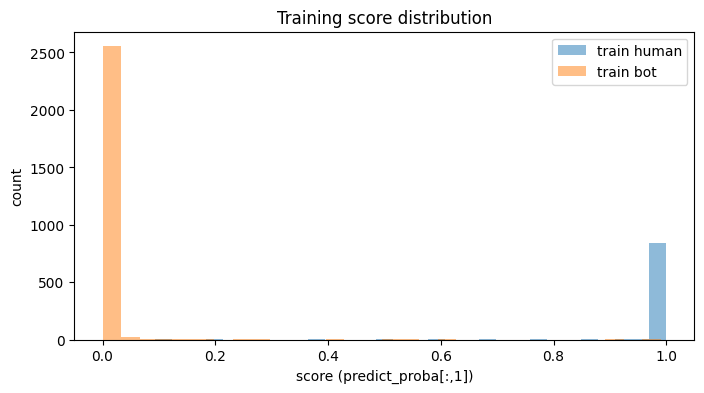

In [58]:
train_probs = model.predict_proba(X_train_all)[:, 1]

print("Mean score | TRAIN humans (y=1):", train_probs[y_train_all == 1].mean())
print("Mean score | TRAIN bots   (y=0):", train_probs[y_train_all == 0].mean())

for thr in [0.2, 0.3, 0.4, 0.5, 0.6]:
    p_h_above = (train_probs[y_train_all == 1] >= thr).mean()
    p_b_above = (train_probs[y_train_all == 0] >= thr).mean()
    print(
        f"thr={thr:.1f}: P(score>=thr | train human)={p_h_above:.3f}, "
        f"P(score>=thr | train bot)={p_b_above:.3f}"
    )

plt.figure(figsize=(8,4))
plt.hist(train_probs[y_train_all == 1], bins=30, alpha=0.5, label="train human")
plt.hist(train_probs[y_train_all == 0], bins=30, alpha=0.5, label="train bot")
plt.xlabel("score (predict_proba[:,1])")
plt.ylabel("count")
plt.legend()
plt.title("Training score distribution")
plt.show()

In [59]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(
    model,
    X_train_all,
    y_train_all,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)

print("5-fold ROC-AUC:", cv_auc)
print("Mean AUC:", cv_auc.mean())

5-fold ROC-AUC: [0.99880136 0.99966393 0.99992128 0.99916619 0.99980845]
Mean AUC: 0.9994722418802835


In [60]:
importances = model.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
fi

duration        0.371597
straightness    0.147032
dt_std          0.053556
jerk_max        0.050243
dt_mean         0.049037
acc_max         0.042957
acc_mean        0.038363
n_points        0.032173
speed_max       0.028738
dt_max          0.027552
jerk_std        0.027020
curvature       0.022906
path_length     0.022665
jitter_index    0.021122
displacement    0.018416
acc_std         0.016409
speed_std       0.011363
speed_mean      0.009590
jerk_mean       0.009260
dtype: float32

In [42]:
from glob import glob

# -------- CHANGE THIS: define where your final-human raw traces live ----------
FINAL_HUMAN_FOLDER = "/Users/naman/sem_1_2025_26/scalable_computing/final_project/web_bot_detection_training/test_set"   # e.g. "test_set/circles_human_tel"
final_human_files = sorted(glob(os.path.join(FINAL_HUMAN_FOLDER, "*.txt")))
print("Final human files:", len(final_human_files))
# -----------------------------------------------------------------------------

def build_features_for_files(file_list):
    rows = []
    files_ok = []
    for path in file_list:
        try:
            times, xs, ys, vw, vh = load_mouse_trace(path)
            if len(times) < 2 or len(xs) < 2:
                continue
            xs_norm = xs / vw
            ys_norm = ys / vh
            feats = extract_features(times, xs_norm, ys_norm)
            rows.append([feats[c] for c in feature_cols])
            files_ok.append(path)
        except Exception as e:
            print(f"[FINAL HUMAN] Error {path}: {e}")
    X = np.array(rows, dtype=float)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X, files_ok

X_final_h, final_files_ok = build_features_for_files(final_human_files)
final_probs = model.predict_proba(X_final_h)[:, 1]

print("Final humans: count =", len(final_files_ok))
print(pd.Series(final_probs).describe())

plt.figure(figsize=(8,4))
plt.hist(train_probs[y_train_all == 1], bins=30, alpha=0.5, label="TRAIN humans")
plt.hist(final_probs, bins=30, alpha=0.5, label="FINAL humans")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.title("Train humans vs final humans – score distribution")
plt.show()

Final human files: 0


XGBoostError: [01:20:37] /Users/runner/work/xgboost/xgboost/src/predictor/cpu_predictor.cc:719: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 19) : Number of columns in data must equal to trained model.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000159708994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000159908e60 void xgboost::predictor::CPUPredictor::DispatchedInplacePredict<xgboost::data::ArrayAdapter, 64ul>(std::__1::any const&, std::__1::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const + 344
  [bt] (2) 3   libxgboost.dylib                    0x0000000159900068 xgboost::predictor::CPUPredictor::InplacePredict(std::__1::shared_ptr<xgboost::DMatrix>, xgboost::gbm::GBTreeModel const&, float, xgboost::PredictionCacheEntry*, unsigned int, unsigned int) const + 1572
  [bt] (3) 4   libxgboost.dylib                    0x0000000159833108 xgboost::gbm::GBTree::InplacePredict(std::__1::shared_ptr<xgboost::DMatrix>, float, xgboost::PredictionCacheEntry*, int, int) const + 432
  [bt] (4) 5   libxgboost.dylib                    0x000000015985190c xgboost::LearnerImpl::InplacePredict(std::__1::shared_ptr<xgboost::DMatrix>, xgboost::PredictionType, float, xgboost::HostDeviceVector<float>**, int, int) + 164
  [bt] (5) 6   libxgboost.dylib                    0x000000015972c1d4 InplacePredictImpl(std::__1::shared_ptr<xgboost::DMatrix>, char const*, xgboost::Learner*, unsigned long long const**, unsigned long long*, float const**) + 276
  [bt] (6) 7   libxgboost.dylib                    0x000000015972ca88 XGBoosterPredictFromDense + 436
  [bt] (7) 8   libffi.dylib                        0x00000001a6360050 ffi_call_SYSV + 80
  [bt] (8) 9   libffi.dylib                        0x00000001a6368af0 ffi_call_int + 1220



In [61]:
import numpy as np
import pandas as pd
import joblib

# Paths
MODEL_PATH = "mouse_model_xgb_2.pkl"   # or mouse_model_xgb.pkl
DATA_PATH  = "cleaned_data.csv"

# Load data to recover feature names
df_all = pd.read_csv(DATA_PATH)

base_non_feature_cols = ["label", "session_id", "phase", "subset"]
drop_task_features = [
    "duration",
    "straightness",
    "n_points",
    "path_length",
    "displacement",
]
import matplotlib.pyplot as plt

names = [f for f, _ in feat_imp]
vals  = [v for _, v in feat_imp]

plt.figure(figsize=(8, 4))
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), names, rotation=45, ha="right")
plt.tight_layout()
plt.title("XGBoost feature importances")
plt.show()
non_feature_cols = set(base_non_feature_cols + drop_task_features)
feature_cols = [c for c in df_all.columns if c not in non_feature_cols]

print("Number of features:", len(feature_cols))
print("Feature columns:", feature_cols)

# Load model
model = joblib.load(MODEL_PATH)

# Get importances
importances = model.feature_importances_

# Show sorted
feat_imp = sorted(zip(feature_cols, importances), key=lambda x: -x[1])
print("\nFeature importances (sorted):")
for name, imp in feat_imp:
    print(f"{name:15s}  {imp:.6f}")

NameError: name 'feat_imp' is not defined